In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")

episodes = episodes.assign(
    protocol=pd.Categorical(
        episodes.protocol,
        categories=sorted(set(episodes.protocol), key=lambda x: x != "nakamoto"),
    )
)
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    reuse=episodes.reuse.drop_duplicates().sort_values().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.25, 0.3, 0.35, 0.4, 0.45],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'reuse': ['-',
  'alpha25',
  'alpha30',
  'alpha35',
  'alpha40',
  'alpha45',
  'gamma5',
  'gamma50',
  'gamma95'],
 'n_episodes': 100,
 'n_models': 720}

In [4]:
setting_key = [
    "protocol",
    "family",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,reward,subblock_selection,alpha,gamma
0,nakamoto,nakamoto,1,constant,n/a,0.25,0.05
1,nakamoto,nakamoto,1,constant,n/a,0.25,0.50
2,nakamoto,nakamoto,1,constant,n/a,0.25,0.95
3,nakamoto,nakamoto,1,constant,n/a,0.30,0.05
4,nakamoto,nakamoto,1,constant,n/a,0.30,0.50
5,nakamoto,nakamoto,1,constant,n/a,0.30,0.95
6,nakamoto,nakamoto,1,constant,n/a,0.35,0.05
7,nakamoto,nakamoto,1,constant,n/a,0.35,0.50
8,nakamoto,nakamoto,1,constant,n/a,0.35,0.95
9,nakamoto,nakamoto,1,constant,n/a,0.40,0.05


In [5]:
trained_episodes = (
    # episodes.query('kind == "trained" or (family in ["nakamoto", "tailstorm"])')
    episodes.sort_values(setting_key).reset_index(drop=True)
)
trained_episodes[setting_key + ["policy"]]

,protocol,family,k,reward,subblock_selection,alpha,gamma,policy
0,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-kftzt1d1-last
1,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-b000qn9q-last
2,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-9h1k627v-best
3,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-vt2jnrgd-best
4,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-fp1dnqw9-last
...,...,...,...,...,...,...,...,...
304195,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-k8ooy5u0-last
304196,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-y4vwerv7-best
304197,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-mvnfemf5-last
304198,spar-8,spar,8,constant,n/a,0.45,0.95,selfish


In [6]:
model_key = setting_key + ["policy", "kind"]
models = (
    trained_episodes.groupby(model_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
models

/tmp/ipykernel_44221/724410382.py:3: FutureWarning: The provided callable <function mean at 0x7f23c071b310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  trained_episodes.groupby(model_key, observed=True)
/tmp/ipykernel_44221/724410382.py:3: FutureWarning: The provided callable <function std at 0x7f23c071b430> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  trained_episodes.groupby(model_key, observed=True)


,protocol,family,k,reward,subblock_selection,alpha,gamma,policy,kind,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,honest,hard-coded,100,0.250754,0.009886,0.250754,0.009886
1,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-0xlx15v3-best,trained,100,0.017929,0.005761,0.017929,0.005761
2,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-0xlx15v3-last,trained,100,0.013830,0.004417,0.013830,0.004417
3,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-340g0mm5-best,trained,100,0.250982,0.009819,0.250982,0.009819
4,nakamoto,nakamoto,1,constant,n/a,0.25,0.05,ppo-340g0mm5-last,trained,100,0.249938,0.009069,0.249938,0.009069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-y4vwerv7-best,trained,100,0.636760,0.035786,0.636760,0.035786
3038,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-y4vwerv7-last,trained,100,0.633468,0.034287,0.633468,0.034287
3039,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-yiy1x3y9-best,trained,100,0.763051,0.046329,0.763051,0.046329
3040,spar-8,spar,8,constant,n/a,0.45,0.95,ppo-yiy1x3y9-last,trained,100,0.771836,0.047029,0.771836,0.047029


In [7]:
best_models = models.loc[
    models.groupby(setting_key + ["kind"], observed=True).rpp_mean.idxmax()
]
best_models_episodes = pd.merge(
    best_models[model_key], episodes, on=model_key, how="left"
)

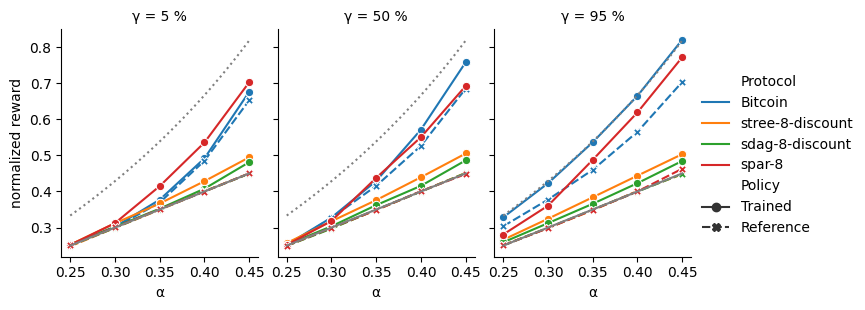

In [8]:
# Some renaming for the paper
def humProtocol(x):
    if x == "nakamoto":
        return "Bitcoin"
    if x == "tailstorm-8-discount":
        return "Tailstorm"
    if x == "tailstorm-8-constant":
        return "TS/const"
    if x == "bk-8":
        return "Bₖ"
    return x


def humPolicy(x):
    if x == "trained":
        return "Trained"
    if x == "hard-coded":
        return "Reference"
    return x


subset = best_models.copy()
subset["Protocol"] = subset.protocol.map(humProtocol)
subset.Protocol = pd.Categorical(
    subset.Protocol  # , categories=["Bitcoin", "TS/const", "Tailstorm", "Bₖ"]
)
subset["Policy"] = subset.kind.map(humPolicy)
subset.Policy = pd.Categorical(subset.Policy, categories=["Trained", "Reference"])
subset["γ"] = subset.gamma.map(lambda x: f"{x * 100:g} %")
subset["α"] = subset.alpha

fig = sns.relplot(
    kind="line",
    data=subset,
    y="rpp_mean",
    x="α",
    col="γ",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.2,
    aspect=0.75,
)
fig.set(ylabel="normalized reward")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(best_models.alpha), max(best_models.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")
    # ax.set_xticks(subset.alpha.drop_duplicates(), labels=subset.alpha.drop_duplicates(), rotation=30)
    ax.set_xticks(subset.alpha.drop_duplicates())


fig.savefig(
    "reward_per_progress_rl.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

In [9]:
# Build and export wide CSV table for pgfplots
def texProtocol(x):
    if x.family == "nakamoto":
        return "seq"
    if x.family == "tailstorm":
        return f"ts{x.k}{x.reward[0]}"
    if x.family in ["spar", "sdag", "stree"]:
        return f"{x.family[1:]}{x.k}{x.reward[0]}"
    if x.family == "bk":
        return f"bk{x.k}"
    assert False


def texPolicy(x):
    if x == "trained":
        return "rl"
    if x == "hard-coded":
        return "hc"
    assert False


subset = best_models.copy()
subset["protocol"] = subset.apply(texProtocol, axis=1)
subset["policy"] = subset.kind.map(texPolicy)
subset["gamma"] = subset.gamma.map(lambda x: f"gamma{int(x * 100):02d}")
wide = subset.pivot(
    index="alpha", columns=["gamma", "protocol", "policy"], values="rpp_mean"
)
wide.columns = ["_".join(col) for col in wide.columns.values]
wide.to_csv("rl-results.csv")
wide

,gamma05_seq_rl,gamma05_seq_hc,gamma50_seq_rl,gamma50_seq_hc,gamma95_seq_rl,gamma95_seq_hc,gamma05_tree8d_rl,gamma05_tree8d_hc,gamma50_tree8d_rl,gamma50_tree8d_hc,...,gamma50_dag8d_rl,gamma50_dag8d_hc,gamma95_dag8d_rl,gamma95_dag8d_hc,gamma05_par8c_rl,gamma05_par8c_hc,gamma50_par8c_rl,gamma50_par8c_hc,gamma95_par8c_rl,gamma95_par8c_hc
alpha,,,,,,,,,,,,,,,,,,,,,
0.25,0.253512,0.250754,0.252464,0.250125,0.328305,0.303681,0.252703,0.247915,0.257174,0.249600,...,0.252427,0.249346,0.259177,0.250493,0.251984,0.250830,0.251812,0.249722,0.280811,0.250732
0.30,0.302181,0.300411,0.327761,0.326846,0.422706,0.377390,0.311835,0.299328,0.317554,0.298664,...,0.303623,0.297046,0.312239,0.299033,0.312331,0.300625,0.318437,0.299580,0.360537,0.298359
0.35,0.377294,0.369377,0.429296,0.415669,0.536266,0.459988,0.366695,0.349365,0.376109,0.348540,...,0.362187,0.349756,0.365880,0.349785,0.414855,0.350894,0.437791,0.348633,0.487567,0.348930
0.40,0.491841,0.485095,0.571490,0.526578,0.664773,0.565258,0.428538,0.400771,0.439521,0.400269,...,0.415654,0.399478,0.422990,0.399687,0.535650,0.399849,0.550525,0.400832,0.619078,0.399995
0.45,0.676181,0.652605,0.758086,0.685038,0.820393,0.703387,0.494608,0.449846,0.505198,0.451279,...,0.486215,0.451230,0.484488,0.448740,0.702562,0.450210,0.692373,0.448289,0.771836,0.463002
